# Additional tips and tricks for designing networks

This tutorial assumes that you have read
the `network_design` tutorial,
and have designed a network or two.
Here, we will give a few advanced tips and tricks
for designing networks that can be reused flexibly.
In particular, these tips will use the
`config` system, so we will also assume that
you have gone over the `config` tutorial.

Briefly, the general principles covered
in this tutorial are

0. Accept `**kwargs` to pass through network arguments
0. Accept a config argument for groups of parameters

We will demonstrate these principles
using the two examples from the `network_design` tutorial.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import nengo
from nengo.dists import Choice
from nengo.processes import Piecewise
from nengo.utils.ipython import hide_input


def test_integrators(net):
    with net:
        piecewise = Piecewise({
            0: 0,
            0.2: 0.5,
            1: 0,
            2: -1,
            3: 0,
            4: 1,
            5: 0
        })
        piecewise_inp = nengo.Node(piecewise)
        nengo.Connection(piecewise_inp, net.pre_integrator.input)
        input_probe = nengo.Probe(piecewise_inp)
        pre_probe = nengo.Probe(net.pre_integrator.ensemble, synapse=0.01)
        post_probe = nengo.Probe(net.post_integrator.ensemble, synapse=0.01)
    with nengo.Simulator(net) as sim:
        sim.run(6)
    plt.figure()
    plt.plot(sim.trange(), sim.data[input_probe], color='k')
    plt.plot(sim.trange(), sim.data[pre_probe], color='b')
    plt.plot(sim.trange(), sim.data[post_probe], color='g')


hide_input()

## 1. Accept a `**kwargs` argument

The standard `nengo.Network` accepts a number of arguments,
including the widely used `seed` and `label` arguments.
Sometimes it is helpful to be able to
set these on your custom networks too.
While there is nothing wrong
with explicitly passing these arguments along,
it is less typing to use the Python `**kwargs` construct.
This special argument allows a function
to accept any number of keyword arguments
which we can then pass into the `Network` constructor.

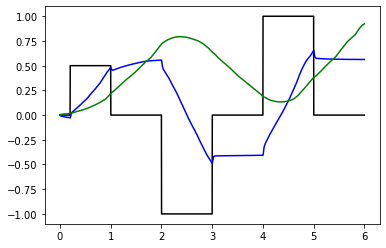

In [2]:
def Integrator(n_neurons, dimensions, tau=0.1, **kwargs):
    with nengo.Network(**kwargs) as net:
        net.input = nengo.Node(size_in=dimensions)
        net.ensemble = nengo.Ensemble(n_neurons, dimensions=dimensions)
        nengo.Connection(net.ensemble, net.ensemble, synapse=tau)
        nengo.Connection(net.input, net.ensemble, synapse=None, transform=tau)
    return net


net = nengo.Network(label="Two integrators")
with net:
    # Make both integrators use LIFRate neurons
    net.config[nengo.Ensemble].neuron_type = nengo.LIFRate()
    net.pre_integrator = Integrator(50, 1, label='pre')
    net.post_integrator = Integrator(50, 1, label='post')
    nengo.Connection(net.pre_integrator.ensemble, net.post_integrator.input)
test_integrators(net)

In [3]:
print('pre integrator label:', net.pre_integrator.label)
print('post integrator label:', net.post_integrator.label)

pre integrator label: pre
post integrator label: post


## 2. Accept a config argument for groups of parameters

Often, you will not want to use the
network-level defaults for all of your objects.
Some objects need certain things overwritten,
while others need other values overwritten.
Again, it is possible to deal with this issue
by adding more and more parameters,
but this quickly gets out of hand.
Instead, add a small number of arguments
that optionally accept a `config` object,
which allows for setting multiple parameters at once.

In the coupled integrator network example,
we make two connections.
We have to be careful changing the defaults
for those connections, as they are wildly different;
one is a recurrent connection from an ensemble to itself,
while the other is a connection from a node to an ensemble.
We will accept a `config` object for the recurrent connection
to make this easier.

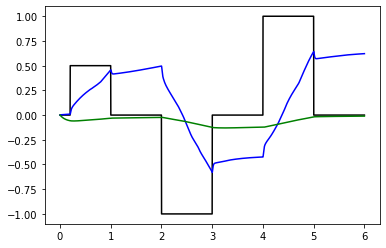

In [4]:
def ConfigurableIntegrator(
        n_neurons, dimensions, recurrent_config=None, **kwargs):
    net = nengo.Network(**kwargs)
    if recurrent_config is None:
        recurrent_config = nengo.Config(nengo.Connection)
        recurrent_config[nengo.Connection].synapse = nengo.Lowpass(0.1)
    with net:
        net.input = nengo.Node(size_in=dimensions)
        net.ensemble = nengo.Ensemble(n_neurons, dimensions=dimensions)
        with recurrent_config:
            nengo.Connection(net.ensemble, net.ensemble)
            tau = nengo.Config.default(nengo.Connection, 'synapse').tau
        nengo.Connection(net.input, net.ensemble, synapse=None, transform=tau)
    return net


net = nengo.Network(label="Two integrators")
with net:
    # Make both integrators use LIFRate neurons
    net.config[nengo.Ensemble].neuron_type = nengo.LIFRate()
    net.pre_integrator = ConfigurableIntegrator(50, 1)
    # Give the post_integrator a shorter tau (should make integration fail)
    recurrent_config = nengo.Config(nengo.Connection)
    recurrent_config[nengo.Connection].synapse = nengo.Lowpass(0.01)
    net.post_integrator = ConfigurableIntegrator(
        50, 1, recurrent_config=recurrent_config)
    nengo.Connection(net.pre_integrator.ensemble, net.post_integrator.input)
test_integrators(net)

## Longer example: double integrator network

Recall in the previous tutorial that
we created a model
that released a lever 0.6 to 1.0 seconds
after pressing a lever.
Let's use the above principles,
and the `config` system in general,
to improve the code constructing this model.

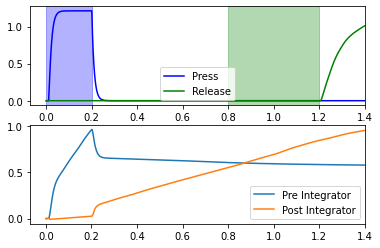

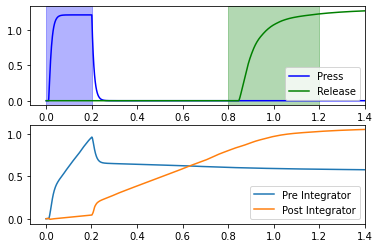

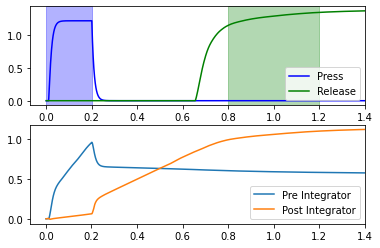

In [5]:
def controlled_integrator(n_neurons,
                          dimensions,
                          recurrent_config=None,
                          **kwargs):
    net = nengo.Network(**kwargs)
    if recurrent_config is None:
        recurrent_config = nengo.Config(nengo.Connection)
        recurrent_config[nengo.Connection].synapse = nengo.Lowpass(0.1)
    with net:
        net.ensemble = nengo.Ensemble(n_neurons, dimensions=dimensions + 1)
        with recurrent_config:
            nengo.Connection(
                net.ensemble,
                net.ensemble[:dimensions],
                function=lambda x: x[:-1] * (1.0 - x[-1]))
    return net


def medial_pfc(coupling_strength,
               n_neurons_per_integrator=200,
               recurrent_config=None,
               tau=0.1,
               **kwargs):
    net = nengo.Network(**kwargs)
    with net:
        recurrent_config = nengo.Config(nengo.Connection)
        recurrent_config[nengo.Connection].synapse = nengo.Lowpass(tau)
        net.pre = controlled_integrator(n_neurons_per_integrator, 1,
                                        recurrent_config)
        net.post = controlled_integrator(n_neurons_per_integrator, 1,
                                         recurrent_config)
        nengo.Connection(
            net.pre.ensemble[0],
            net.post.ensemble[0],
            transform=coupling_strength)
    return net


def motor_cortex(command_threshold,
                 n_neurons_per_command=30,
                 ens_config=None,
                 **kwargs):
    net = nengo.Network(**kwargs)
    if ens_config is None:
        ens_config = nengo.Config(nengo.Ensemble)
        ens_config[nengo.Ensemble].encoders = Choice([[1]])
        ens_config[nengo.Ensemble].intercepts = Choice([command_threshold])
    with net:
        with ens_config:
            net.press = nengo.Ensemble(n_neurons_per_command, dimensions=1)
            net.release = nengo.Ensemble(n_neurons_per_command, dimensions=1)
    return net


def double_integrator(mpfc_coupling_strength,
                      command_threshold,
                      press_to_pre_gain=3,
                      press_to_post_control=-6,
                      recurrent_tau=0.1,
                      **kwargs):
    net = nengo.Network(**kwargs)
    with net:
        net.mpfc = medial_pfc(mpfc_coupling_strength)
        net.motor = motor_cortex(command_threshold)
        nengo.Connection(
            net.motor.press,
            net.mpfc.pre.ensemble[0],
            transform=recurrent_tau * press_to_pre_gain)
        nengo.Connection(
            net.motor.press,
            net.mpfc.post.ensemble[1],
            transform=press_to_post_control)
        nengo.Connection(net.mpfc.post.ensemble[0], net.motor.release)
    return net


def test_doubleintegrator(net):
    # Provide input and probe outside of network construction,
    # for more flexibility
    with net:
        nengo.Connection(
            nengo.Node(lambda t: 1 if t < 0.2 else 0), net.motor.press)
        pr_press = nengo.Probe(net.motor.press, synapse=0.01)
        pr_release = nengo.Probe(net.motor.release, synapse=0.01)
        pr_pre_int = nengo.Probe(net.mpfc.pre.ensemble[0], synapse=0.01)
        pr_post_int = nengo.Probe(net.mpfc.post.ensemble[0], synapse=0.01)
    with nengo.Simulator(net) as sim:
        sim.run(1.4)
    t = sim.trange()
    plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(t, sim.data[pr_press], c='b', label="Press")
    plt.plot(t, sim.data[pr_release], c='g', label="Release")
    plt.axvspan(0, 0.2, color='b', alpha=0.3)
    plt.axvspan(0.8, 1.2, color='g', alpha=0.3)
    plt.xlim(right=1.4)
    plt.legend(loc="best")
    plt.subplot(2, 1, 2)
    plt.plot(t, sim.data[pr_pre_int], label="Pre Integrator")
    plt.plot(t, sim.data[pr_post_int], label="Post Integrator")
    plt.xlim(right=1.4)
    plt.legend(loc="best")


for coupling_strength in (0.11, 0.16, 0.21):
    # Try the same network with LIFRate neurons
    with nengo.Config(nengo.Ensemble) as cfg:
        cfg[nengo.Ensemble].neuron_type = nengo.LIFRate()
        net = double_integrator(
            mpfc_coupling_strength=coupling_strength,
            command_threshold=0.85,
            seed=0)
    test_doubleintegrator(net)